In [1]:
from drivecycle import trajectory, drivecycle, plots, utils
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [26]:
traj = trajectory.const_accel(vi=0,v_target=12,vf=0,di=0,df=450,step=1,a_max=0.5)
traj = traj[1:]

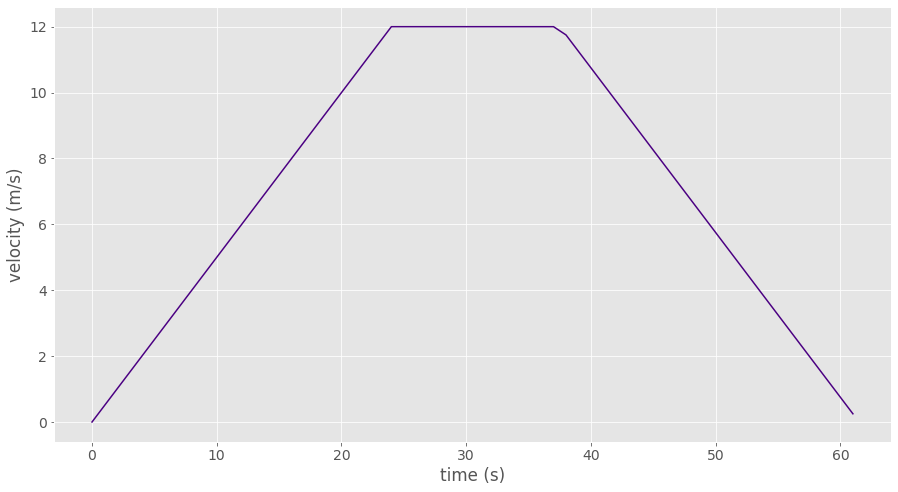

In [27]:
plots.plot_vt(traj, "plot_vt.png")

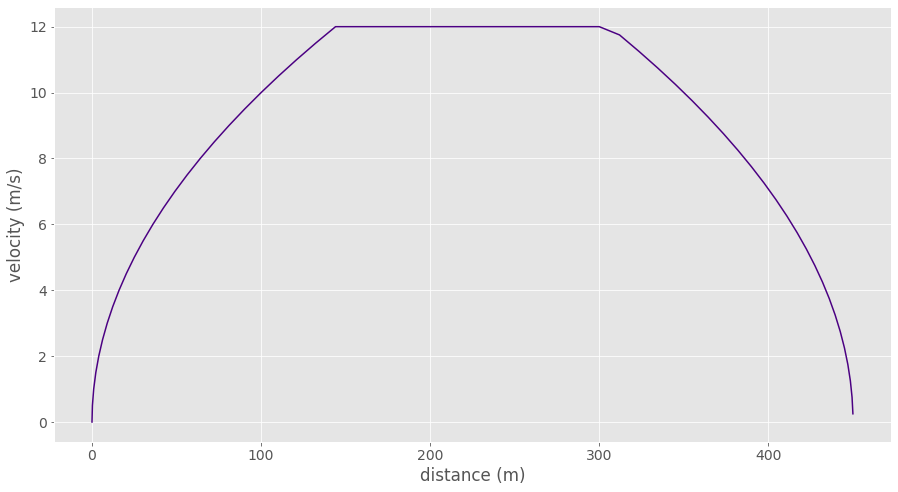

In [28]:
plots.plot_vd(traj, "plot_vd.png")

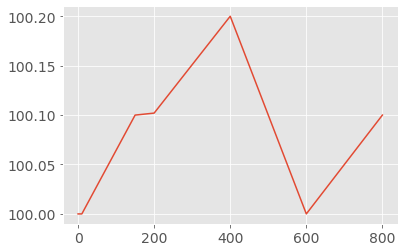

In [29]:
elv = np.array([[0,100],[10,100],[150,100.1],[200,100.102],[400,100.2],[600,100],[800,100.1]])
x = [i[0] for i in elv]
y = [i[1] for i in elv]
    
plt.plot(x,y)

In [30]:
#Energy Calculation

#Rolling Resistance 

#F_r = f * m * g
#f = (0.0041 + 0.000041 * v * 2.24) * Ch

#Aerodynamic Drag

#F_d = 0.5 * air_density * Cw * A * v^2

#Hill Climbing Force

#F_h = m * g * sin(alpha)

#Acceleration Force

#F_a = m * a



In [31]:
def open_circuit_voltage_LA(x,N):
    return (2.15 - ((2.15-2.00)*x))*N

def open_circuit_voltage_NC(x,N):
    return N*( -8.2816 *(np.power(x,7))  +  23.5749*(np.power(x,6)) -30*(np.power(x,5)) +23.7053*(np.power(x,4)) -12.5877*(np.power(x,3)) + 4.1315*x*x - 0.8658*x +1.37)


In [32]:
open_circuit_voltage_LA(0,1)

2.15

In [137]:
def pairwise(iterable):
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def energy(
    traj,
    elv,
    Ch = 1.2,
    m = 12000,
    g = 9.81,
    air_density = 1.2,
    Cw = 1.17,
    A = 10,
    r = 0.5,
):
    
    g_ratio = 37 #G/r
    regen_ratio = 0.5
    g_eff = 0.95 #transmission efficiency
    ki = 0.01 #iron losses
    kw = 0.000005 #windage losses
    kc = 0.3 #copper losses
    ConL = 600
    
    NoCells=200# 
    Capacity=50; #This is the normal 3 h rated capacity of the battery
    k=1.045 #peukert coeff
    
    Rin= (0.022/Capacity)*NoCells #Internal resistance, e.q. (3.9)
    PeuCap= (np.power((Capacity/10),k))*10 #See equation (3.18)

    x = [i[0] for i in elv]
    y = [i[1] for i in elv]
    
    elv_f = interpolate.interp1d(x,y)
    
    power = []
    
    data = np.zeros((len(traj),2)) #Cr, DoD
    
    for i, (prev,curr) in enumerate(pairwise(traj)):

        t0,v0,d0 = prev
        t1,v1,d1 = curr

        accel = (v1-v0)/(t1-t0)
        
        alpha = (elv_f(d1)-elv_f(d0))/(d1-d0)
#         alpha = 0

        f = (0.0041 + 0.000041 * v1 * 2.24) * Ch
    
        Fr = m * f * g
        Fd = 0.5 * air_density * Cw * A * np.power(v1,2)
        Fh = m * g * np.sin(alpha)
        Fa = m * accel

        F = Fr + Fd + Fh + Fa

        Pte = (F*v1) #in Watts
        omega = g_ratio * v1
        
        if omega==0:
            Pte= 0
            Pmot_in= 0
            torque = 0
            eff_mot=0.5
        elif omega>0:
            if Pte<0:
                Pte = regen_ratio * Pte
        
            if Pte >=0:
                Pmot_out = Pte/g_eff
            elif Pte<0:
                Pmot_out = Pte*g_eff
        
            torque = Pmot_out/omega
        
            if torque > 0:
                eff_mot = (torque*omega)/((torque*omega)+(np.power(torque,2)*kc)+(omega*ki)+((np.power(omega,3)*kw)+ConL))
            elif torque<0:
                eff_mot = (-torque*omega)/((-torque*omega)+(np.power(torque,2)*kc)+(omega*ki)+((np.power(omega,3)*kw)+ConL))
        
            if Pmot_out >=0:
                Pmot_in = Pmot_out/eff_mot
            elif Pmot_out <0:
                Pmot_in = Pmot_out * eff_mot
        
        Pac = 0 #accessory power
        Pbat = Pmot_in + Pac
        
        E=open_circuit_voltage_LA(data[i,1],NoCells)
        
        if Pbat > 0: 
            a = np.power(E,2)-(4*Rin*Pbat)
            assert a>0, "Need more power"
            
            I = (E - np.sqrt(a))/(2*Rin)
            data[i+1,0] = data[i,0] +(np.power(I,k)/3600); 
            
        elif Pbat==0:
            I=0
        elif Pbat <0:
            #Regenerative braking double the internal resistance.
        
            a = np.power(E,2)-(4*2*Rin*-Pbat)
            assert a>0, "Need more power"
            
            I = (-E + np.sqrt(a))/(2*2*Rin)
            data[i+1,0] = data[i,0] - (I/3600); #%Equation (3.29)**
        
        
        data[i+1,1] = data[i+1,0]/PeuCap
        power.append([t1,Pbat])
        
        
    return power, data

        
power, data = energy(traj,elv)

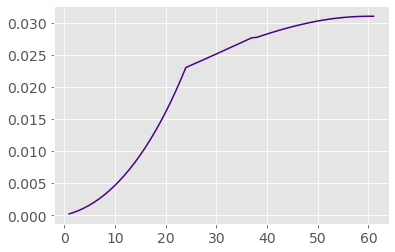

In [138]:
t=[i[0] for i in power]
# p=[i[1] for i in power]

p=[i[1] for i in data[1:]]

plt.plot(t,p, color='#4b0082', linewidth=1.5)